In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv
/kaggle/input/cbfitmodels/cbfit_Singapore
/kaggle/input/cbfitmodels/cbfit_Italy
/kaggle/input/cbfitmodels/cbfit_Finland
/kaggle/input/cbfitmodels/cbfit_Canada
/kaggle/input/cbfitmodels/cbfit_Norway
/kaggle/input/cbfitmodels/cbfit_Kenya
/kaggle/input/cbfitmodels/__results___files/__results___9_0.png
/kaggle/input/cbfitmodels/__results___files/__results___64_1.png
/kaggle/input/cbfitmodels/__results___files/__results___13_0.png
/kaggle/input/cbfitmodels/catboost_info/test_error.tsv
/kaggle/input/cbfitmodels/catboost_info/learn_error.tsv
/kaggle/input/cbfitmodels/catboost_info/catboost_training.json
/kaggle/input/cbfitmodels/catboost_info/time_left.tsv
/kaggle/input/cbfitmodels/catboost_info/learn/events.out.tfevents
/kaggle/input/cbfitmodels/catboost_info/test/events.out.tfevents


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

# Sample quarterly data
# data = {'quarter': [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
#         'value': [10, 15, 12, 18, 11, 16, 13, 19, 12, 17, 14, 20]}
# df = pd.DataFrame(data)

# # Create periodic spline transformer
# qt = periodic_spline_transformer(12, 4)

# # Transform the 'quarter' feature
# quarter = qt.fit_transform(df_train[['Month']])[:,0]

# # Add transformed features to DataFrame
# print(quarter)

In [3]:
check_pg=[]

In [4]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    check_pg.append(freqencies)
    check_pg.append(spectrum)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    plt.savefig('pg.png')
    return ax

In [5]:
!pip install optuna-integration[catboost]
!pip install -U holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.57
    Uninstalling holidays-0.57:
      Successfully uninstalled holidays-0.57


In [6]:
!pip install -U pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 58.3 MB/s eta 0:00:00


In [7]:
import statsmodels

In [8]:
import pandas as pd
import numpy as np
import optuna
import catboost as cb
import matplotlib
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from optuna.integration import CatBoostPruningCallback
import pycountry 
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess




In [9]:
df_train=pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')



In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [11]:
df_train['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [12]:
df_train[df_train['country']=='Kenya']['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [13]:
df_train['product'].unique()

array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode'], dtype=object)

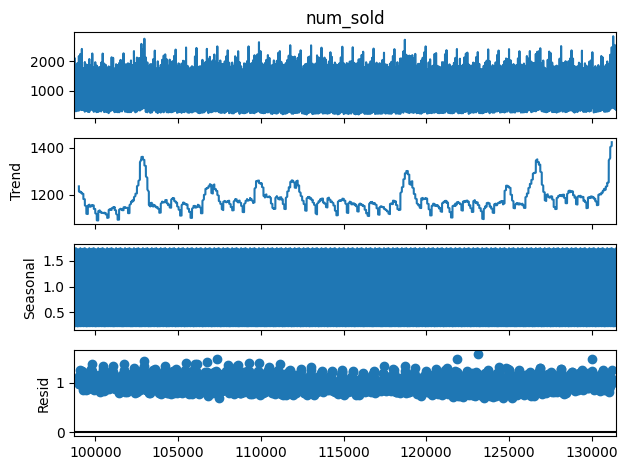

In [14]:
### import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
#df_train['date']=pd.to_datetime(df_train['date'])
#df_train=df_train.set_index('date')
df=df_train['num_sold']

#time = pd.date_range(start=df_train['date'].min, end=df_train['date'].max, periods=365, freq='D')
#series = 10 + 0.05 * np.arange(100) + np.sin(2 * np.pi * time.dayofyear / 365) + np.random.normal(0, 1, 100)
#df = pd.DataFrame({'date': time, 'value': series}).set_index('date')

# Decompose time series
decomposition = seasonal_decompose(
    df_train[(df_train['country']=='Singapore') & 
    (df_train['date'].str.contains('2013')) &
    (df_train['store']=='Premium Sticker Mart')]['num_sold'],
    model='multiplicative', period=30)  # Set period according to data frequency

# Plot components
decomposition.plot()
plt.show()


In [15]:
# temp=pd.concat([df_train['date'],df_train['num_sold']],axis=1)
# sumsale2016=temp.groupby('date').mean().squeeze().loc['2013']
# #sumsale2016
# plot_periodogram(sumsale2016)

In [16]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'])

# Print results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")


ADF Statistic: -6.129147123657372
p-value: 8.484833374009022e-08
The series is stationary.


In [17]:
from statsmodels.tsa.stattools import kpss

# Perform KPSS test
kpss_result = kpss(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], regression='c')

# Print results
print("KPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
if kpss_result[1] < 0.05:
    print("The series is not stationary (has a trend).")
else:
    print("The series is stationary.")

KPSS Statistic: 0.7976600279714846
p-value: 0.01
The series is not stationary (has a trend).


<ipython-input-17-b1e5399dac4b>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], regression='c')


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


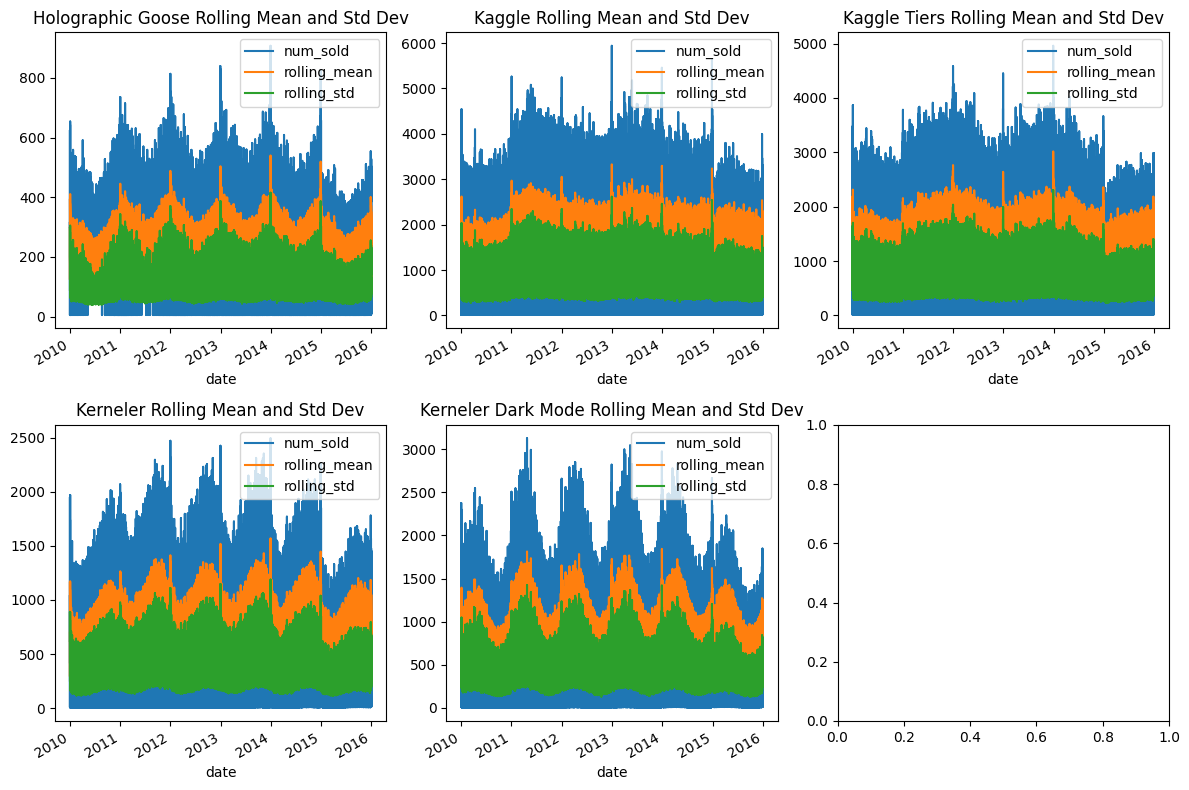

In [19]:
# Plot showing timeseries attributes: trend, seasonality 

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()
productlist=df_train['product'].unique().tolist()
# Loop through each subplot and plot
for i, ax in enumerate(axes):
    if i<len(productlist):
        df=df_train[(df_train['product']==productlist[i])][['date','num_sold']]
        df.dropna(inplace=True)
        df['date']=pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        df=df.loc['2010':'2015',:]
        df['rolling_mean'] = df['num_sold'].rolling(window=5).mean()
        df['rolling_std'] = df['num_sold'].rolling(window=5).std()
        df[['num_sold', 'rolling_mean', 'rolling_std']].plot(ax=ax,title=f'{productlist[i]} Rolling Mean and Std Dev')
    
plt.tight_layout()

# Show the plot
plt.show()
    

In [20]:
df_train.loc[df_train['country']=='Canada',['store','num_sold']].mode()

,store,num_sold
0,Discount Stickers,218.0
1,Premium Sticker Mart,NaN
2,Stickers for Less,NaN


In [21]:
df_train.iloc[df_train[df_train.isna().any(axis=1)].index,:].groupby(by=['country','store']).count()

id  date  product  num_sold
country store                                              
Canada  Discount Stickers     2558  2558     2558         0
        Premium Sticker Mart   380   380      380         0
        Stickers for Less     1308  1308     1308         0
Kenya   Discount Stickers     2621  2621     2621         0
        Premium Sticker Mart   646   646      646         0
        Stickers for Less     1358  1358     1358         0

In [22]:


def get_alpha2_code(country_name):
  """
  Gets the ISO 3166-1 Alpha-2 country code for the given country name.

  Args:
    country_name: The name of the country.

  Returns:
    The ISO 3166-1 Alpha-2 country code, or None if the country is not found.
  """
  try:
    country = pycountry.countries.search_fuzzy(country_name)[0]
    return country.alpha_2
  except LookupError:
    return None



In [23]:
# Function to create holiday sets for each country
def generate_country_holidays(countries, start_year, end_year):
    country_holidays = {}
    for country in countries:
        # Generate a holiday set for the range of years
        country_holidays[country] = holidays.CountryHoliday(country, years=range(start_year, end_year + 1)) 
    return country_holidays


In [24]:
df_train['Day']=pd.to_datetime(df_train['date']).dt.strftime("%d")
df_train['Month']=pd.to_datetime(df_train['date']).dt.strftime("%m")
df_train['Year']=pd.to_datetime(df_train['date']).dt.strftime("%Y")
df_train['Day_of_week']=pd.to_datetime(df_train['date']).dt.dayofweek
df_train['Week_No']=pd.to_datetime(df_train['date']).dt.isocalendar().week
df_train['is_weekend']=(df_train['Day_of_week']>=4).astype(int)
df_train['Quarter_Discrete'] = (df_train['Month'].astype(int) - 1) // 3 + 1
df_train['quarter_normalized'] = (df_train['Quarter_Discrete']-1)/3
df_train['month_normalized']=(df_train['Month'].astype(int)-1)/11
#df_train['Month_Spline']=periodic_spline_transformer(12,4).fit_transform(df_train[['quarter_normalized']])[:,0]
#df_train['Quarter_Spline']=periodic_spline_transformer(4,4).fit_transform(df_train[['quarter_normalized']])[:,0]
df_train['week_number_normalized'] = df_train['Week_No'] / df_train['Week_No'].max()
#df_train['Week_Spline']=periodic_spline_transformer(53,5).fit_transform(df_train[['week_number_normalized']])[:,0]

In [25]:
def consecutive_days_visited(df):
    """
    Calculates the number of consecutive days a store was visited.

    Args:
        df: pandas DataFrame with columns 'date', 'country', 'store'

    Returns:
        pandas DataFrame with an additional column 'consecutive_days' 
    """

    # Ensure date index is sorted
    df = df.sort_index()

    # Group by 'country' and 'store'
    grouped = df.groupby(['country', 'store'])

    # Calculate consecutive days within each group
    df['consecutive_days'] = (grouped.indices - grouped.indices.min()).dt.days + 1

    return df


In [26]:
allcountries=df_train['country'].unique()
countrycodes = list(map(lambda x:get_alpha2_code(x),allcountries)) 
unique_countries = [cc for cc in countrycodes if cc is not None]
print(countrycodes)

['CA', 'FI', 'IT', 'KE', 'NO', 'SG']


In [27]:
df_train['store']=df_train['store'].astype('category')
df_train['country']=df_train['country'].astype('category')
df_train['product']=df_train['product'].astype('category')
df_train['Day']=df_train['Day'].astype('category')
df_train['Month']=df_train['Month'].astype('category')
df_train['Year']=df_train['Year'].astype('category')
df_train['Day_of_week']=df_train['Day_of_week'].astype('category')


In [28]:
df_test['Day']=pd.to_datetime(df_test['date']).dt.strftime("%d")
df_test['Month']=pd.to_datetime(df_test['date']).dt.strftime("%m")
df_test['Year']=pd.to_datetime(df_test['date']).dt.strftime("%Y")
df_test['Day_of_week']=pd.to_datetime(df_test['date']).dt.dayofweek
df_test['Week_No']=pd.to_datetime(df_test['date']).dt.isocalendar().week
df_test['is_weekend']=(df_test['Day_of_week']>=4).astype(int)
df_test['Quarter_Discrete'] = (df_test['Month'].astype(int) - 1) // 3 + 1
df_test['quarter_normalized'] = (df_test['Quarter_Discrete']-1)/3
df_test['month_normalized']=(df_test['Month'].astype(int)-1)/11
#df_test['Month_Spline']=periodic_spline_transformer(12,4).fit_transform(df_test[['quarter_normalized']])[:,0]
#df_test['Quarter_Spline']=periodic_spline_transformer(4,4).fit_transform(df_test[['quarter_normalized']])[:,0]
df_test['week_number_normalized'] = df_test['Week_No'] / df_test['Week_No'].max()
#df_test['Week_Spline']=periodic_spline_transformer(53,5).fit_transform(df_test[['week_number_normalized']])[:,0]


In [29]:
df_test.drop(['week_number_normalized','month_normalized','quarter_normalized'],axis=1,inplace=True)

In [30]:
df_train.drop(['week_number_normalized','month_normalized','quarter_normalized'],axis=1,inplace=True)

In [31]:
df_test['store']=df_test['store'].astype('category')
df_test['country']=df_test['country'].astype('category')
df_test['product']=df_test['product'].astype('category')
df_test['Day']=df_test['Day'].astype('category')
df_test['Month']=df_test['Month'].astype('category')
df_test['Year']=df_test['Year'].astype('category')
df_test['Day_of_week']=df_test['Day_of_week'].astype('category')


In [32]:
df_train['date']=pd.to_datetime(df_train['date'])
df_test['date']=pd.to_datetime(df_test['date'])

In [33]:
df_train['previous_visit']=df_train.reset_index().groupby(by=['country','store'])[['date']].diff()

<ipython-input-33-a9a4f327ce0c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['previous_visit']=df_train.reset_index().groupby(by=['country','store'])[['date']].diff()


In [34]:
df_train['consec_days']=df_train.groupby(by=['country','store'])[['previous_visit']].cumsum()

<ipython-input-34-9b789beb13f0>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['consec_days']=df_train.groupby(by=['country','store'])[['previous_visit']].cumsum()


In [35]:
df_test['previous_visit']=df_test.reset_index().groupby(by=['country','store'])[['date']].diff()
df_test['consec_days']=df_test.groupby(by=['country','store'])[['previous_visit']].cumsum()

<ipython-input-35-b64440241ea2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test['previous_visit']=df_test.reset_index().groupby(by=['country','store'])[['date']].diff()
<ipython-input-35-b64440241ea2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test['consec_days']=df_test.groupby(by=['country','store'])[['previous_visit']].cumsum()


In [36]:
df_train.set_index('date',inplace=True)
Startmin=df_train.index.min()
df_train['days_since_start'] = (df_train.index - Startmin).days

# Add cycle hints based on time 
df_train['sin_year'] = np.sin(2 * np.pi * df_train['days_since_start'] / 365)
df_train['cos_year'] = np.cos(2 * np.pi * df_train['days_since_start'] / 365)
df_train['sin_month'] = np.sin(2 * np.pi * df_train['days_since_start'] / 30)
df_train['cos_month'] = np.cos(2 * np.pi * df_train['days_since_start'] / 30)

df_test.set_index('date',inplace=True)
df_test['days_since_start'] = (df_test.index - Startmin).days

# Add cycle hints based on time 
df_test['sin_year'] = np.sin(2 * np.pi * df_test['days_since_start'] / 365)
df_test['cos_year'] = np.cos(2 * np.pi * df_test['days_since_start'] / 365)
df_test['sin_month'] = np.sin(2 * np.pi * df_test['days_since_start'] / 30)
df_test['cos_month'] = np.cos(2 * np.pi * df_test['days_since_start'] / 30)

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   date              230130 non-null  datetime64[ns] 
 1   id                230130 non-null  int64          
 2   country           230130 non-null  category       
 3   store             230130 non-null  category       
 4   product           230130 non-null  category       
 5   num_sold          221259 non-null  float64        
 6   Day               230130 non-null  category       
 7   Month             230130 non-null  category       
 8   Year              230130 non-null  category       
 9   Day_of_week       230130 non-null  category       
 10  Week_No           230130 non-null  UInt32         
 11  is_weekend        230130 non-null  int64          
 12  Quarter_Discrete  230130 non-null  int64          
 13  previous_visit    230112 non-null  timedelta

In [38]:
#Get country

#Get holidays for each country
#allcountries.append("weirdcountry")
country_holidays={}

#df_train['date']=pd.to_datetime(df_train['date'])
start_year = df_train['date'].dt.year.min()
end_year = df_train['date'].dt.year.max()

country_holidays = generate_country_holidays(unique_countries, start_year, end_year)
holiday_df = pd.DataFrame([
    {'date': date, 'country_code': country, 'country': cname}
    for country in unique_countries
    for date in country_holidays[country]
    for cname in [pycountry.countries.get(alpha_2=cc).name for cc in unique_countries]]
)
holiday_df['is_holiday'] = 1
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.drop('country_code',axis=1,inplace=True)

df_train = df_train.merge(holiday_df, on=['date', 'country'], how='left').fillna({'is_holiday': 0})

In [39]:
start_year = df_test['date'].dt.year.min()
end_year = df_test['date'].dt.year.max()
#unique_countries = [cc for cc in countrycodes if cc is not None]
country_holidays = generate_country_holidays(unique_countries, start_year, end_year)

holiday_df = pd.DataFrame([
    {'date': date, 'country_code': country, 'country': cname}
    for country in unique_countries
    for date in country_holidays[country]
    for cname in [pycountry.countries.get(alpha_2=cc).name for cc in unique_countries]]
)
holiday_df['is_holiday']=1
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.drop('country_code',axis=1,inplace=True)

df_test = df_test.merge(holiday_df, on=['date', 'country'], how='left').fillna({'is_holiday': 0})


In [40]:
df_test['is_holiday']=df_test['is_holiday'].astype(int)
df_test['is_holiday'].value_counts()

is_holiday
0    88290
1    18270
Name: count, dtype: int64

In [41]:
df_train.set_index('date',inplace=True)
df_test.set_index('date',inplace=True)

In [42]:
#Graph for intrpolate is changing too much
#Not interpolate but just drop Na is better
#Interpolate missing num_sold

#df_train['date']=pd.to_datetime(df_train['date'])
#df = df_train.set_index('date')

# df_train = df_train.sort_values(by=['country', 'store', 'product', 'date'])

# # Impute NaN with interpolation (grouped by Country, Store, and Product)
# df_train['num_sold'] = df_train.groupby(['country', 'store', 'product'])['num_sold'].transform(
#     lambda group: group.interpolate(method='linear',limit=None,limit_direction='both').ffill().bfill()
# )
#df['num_sold'].isna().any()

In [43]:
#condition = (df.num_sold.notna()) & (df['country']=='Canada') & (df['store']=='Discount Stickers') & (df['product']=='Holographic Goose')
#df[condition]


In [44]:
##Get num_sold NaN product store and country
#t=df[df.num_sold.isna()].groupby(['country','store','product'])['product'].value_counts().to_dict()

In [45]:
#Country store and product that have NaN
# for  k,v in t.items():
#     if v!=0:
#         print(k,v)

Impute Canana NaN with 218.0 
Impute Kenya NaN with 5.0

In [46]:
df_train['previous_visit'].fillna(pd.to_timedelta(0),inplace=True)
df_train['consec_days'].fillna(pd.to_timedelta(0),inplace=True)
df_test['previous_visit'].fillna(pd.to_timedelta(0),inplace=True)
df_test['consec_days'].fillna(pd.to_timedelta(0),inplace=True)

df_train.dropna(inplace=True)
#df_test.dropna(inplace=True)

In [47]:
#Drop Na instead of impute
df_train.dropna(inplace=True)

In [48]:
#Impute Canada with 218
#df_train.loc[df_train['country']=='Canada',['num_sold']]=df_train.loc[df_train['country']=='Canada',['num_sold']].fillna(218.0)

In [49]:
#Impute Kenya with 5
#df_train.loc[df_train['country']=='Kenya',['num_sold']]=df_train.loc[df_train['country']=='Kenya',['num_sold']].fillna(5.0)

In [50]:
# nsmode = df_train['num_sold'].mode()
# df_train['num_sold']=df_train['num_sold'].fillna(nsmode[0])

In [51]:
df_train.isna().any()

id                  False
country             False
store               False
product             False
num_sold            False
Day                 False
Month               False
Year                False
Day_of_week         False
Week_No             False
is_weekend          False
Quarter_Discrete    False
previous_visit      False
consec_days         False
days_since_start    False
sin_year            False
cos_year            False
sin_month           False
cos_month           False
is_holiday          False
dtype: bool

In [52]:
df_train['is_holiday']=df_train['is_holiday'].astype('int')
df_train['previous_visit']=pd.to_numeric(df_train['previous_visit'].dt.days,errors='coerce')
df_train['consec_days']=pd.to_numeric(df_train['consec_days'].dt.days,errors='coerce')
df_train['country']=df_train['country'].astype('category')

df_test['is_holiday']=df_test['is_holiday'].astype('int')
df_test['previous_visit']=pd.to_numeric(df_test['previous_visit'].dt.days,errors='coerce')
df_test['consec_days']=pd.to_numeric(df_test['consec_days'].dt.days,errors='coerce')
df_test['country']=df_test['country'].astype('category')

In [53]:
#log transform target
df_train['num_sold']=np.log1p(df_train['num_sold']) 


In [54]:
#Split data according to country into
from catboost import Pool
cv_product_train_pool={}
product_train_pool={}
product_valid_pool={}
productlist=['Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode', 'Holographic Goose']

for p in productlist:
    df=df_train[df_train['product']==p].reset_index()
    train_x, valid_x, train_y, valid_y = train_test_split(df.drop(['id','num_sold','product'],axis=1),df['num_sold'],shuffle=False,test_size=0.20)
    cvtrain_x, cvvalid_x, cvtrain_y, cvvalid_y = train_test_split(df.drop(['id','num_sold','product'],axis=1),df['num_sold'],shuffle=False,test_size=0.10) 
    cats=df.select_dtypes('category').columns.to_list()
    cats.remove('product')
    cats.append('is_holiday')
    cats.append('Week_No')
    cats.append('is_weekend')
    cats.append('Quarter_Discrete')
    #train_weights = np.linspace(0.1, 1.0, len(train_x))
    #valid_weights = np.linspace(0.1, 1.0, len(valid_x)) # Linearly increasing weights
    # decay_rate=0.75
    # train_weights = decay_rate ** np.arange(len(train_x))[::-1]  # Exponentially increasing weights
    # valid_weights = decay_rate ** np.arange(len(valid_x))[::-1]  # Exponentially increasing weights
    cv_product_train_pool[p]=Pool(cvtrain_x,label=cvtrain_y,cat_features=cats)
    product_train_pool[p]=Pool(train_x,label=train_y,cat_features=cats)#,weight=train_weights)
    product_valid_pool[p]=Pool(valid_x,label=valid_y,cat_features=cats)#,weight=valid_weights)
    print(f"{p} train date {train_x['date'].min()} to {train_x['date'].max()}")
    print(f"{p} train loc  {train_x.index.min()} to {train_x.index.max()}")
    print(f"{p} valid date {valid_x['date'].min()} to {valid_x['date'].max()}") 
    print(f"{p} valid loc {valid_x.index.min()} to {valid_x.index.max()}")

Kaggle train date 2010-01-01 00:00:00 to 2015-08-04 00:00:00
Kaggle train loc  0 to 39959
Kaggle valid date 2015-08-05 00:00:00 to 2016-12-31 00:00:00
Kaggle valid loc 39960 to 49949
Kaggle Tiers train date 2010-01-01 00:00:00 to 2015-08-04 00:00:00
Kaggle Tiers train loc  0 to 39959
Kaggle Tiers valid date 2015-08-05 00:00:00 to 2016-12-31 00:00:00
Kaggle Tiers valid loc 39960 to 49949
Kerneler train date 2010-01-01 00:00:00 to 2015-08-05 00:00:00
Kerneler train loc  0 to 39905
Kerneler valid date 2015-08-05 00:00:00 to 2016-12-31 00:00:00
Kerneler valid loc 39906 to 49882
Kerneler Dark Mode train date 2010-01-01 00:00:00 to 2015-08-04 00:00:00
Kerneler Dark Mode train loc  0 to 39958
Kerneler Dark Mode valid date 2015-08-05 00:00:00 to 2016-12-31 00:00:00
Kerneler Dark Mode valid loc 39959 to 49948
Holographic Goose train date 2010-01-01 00:00:00 to 2015-08-17 00:00:00
Holographic Goose train loc  0 to 32425
Holographic Goose valid date 2015-08-17 00:00:00 to 2016-12-31 00:00:00
Holo

In [55]:
# #Split data according to country into
# from catboost import Pool
# cv_country_train_pool={}
# country_train_pool={}
# country_valid_pool={}
# countrylist=['Canada','Finland','Italy','Kenya','Norway','Singapore']

# for c in countrylist:
#     df=df_train[df_train['country']==c]
#     train_x, valid_x, train_y, valid_y = train_test_split(df.drop(['id','num_sold','country'],axis=1),df['num_sold'],shuffle=False,test_size=0.20)
#     cvtrain_x, cvvalid_x, cvtrain_y, cvvalid_y = train_test_split(df.drop(['id','num_sold','country'],axis=1),df['num_sold'],shuffle=False,test_size=0.10) 
#     cats=df.select_dtypes('category').columns.to_list()
#     cats.remove('country')
#     cats.append('is_holiday')
#     cats.append('Week_No')
#     cats.append('is_weekend')
#     cats.append('Quarter_Discrete')
#     #train_weights = np.linspace(0.1, 1.0, len(train_x))
#     #valid_weights = np.linspace(0.1, 1.0, len(valid_x)) # Linearly increasing weights
#     # decay_rate=0.75
#     # train_weights = decay_rate ** np.arange(len(train_x))[::-1]  # Exponentially increasing weights
#     # valid_weights = decay_rate ** np.arange(len(valid_x))[::-1]  # Exponentially increasing weights
#     cv_country_train_pool[c]=Pool(cvtrain_x,label=cvtrain_y,cat_features=cats)
#     country_train_pool[c]=Pool(train_x,label=train_y,cat_features=cats)#,weight=train_weights)
#     country_valid_pool[c]=Pool(valid_x,label=valid_y,cat_features=cats)#,weight=valid_weights)
#     print(f"{c} train date {train_x['date'].min()} to {train_x['date'].max()}")
#     print(f"{c} train loc  {train_x.index.min()} to {train_x.index.max()}")
#     print(f"{c} valid date {valid_x['date'].min()} to {valid_x['date'].max()}") 
#     print(f"{c} valid loc {valid_x.index.min()} to {valid_x.index.max()}")

In [56]:
from functools import partial
from catboost import cv

def objective(trial: optuna.Trial, product,resid_y) -> float:
    #data, target = load_breast_cancer(return_X_y=True)
    #train_x, valid_x, train_y, valid_y = train_test_split(df_train.drop(['id','num_sold','date'],axis=1), df_train['num_sold'], test_size=0.25)
    #cats=df_train.select_dtypes('category').columns
    
    param = {
        "iterations":trial.suggest_int("iterations",1000,7000),
        "learning_rate":trial.suggest_float("learning_rate",0.006,0.03,log=True),
        "objective": trial.suggest_categorical("objective", ["MAPE"]),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.7, log=True), #this is not for GPU
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "1gb",
        "eval_metric": "MAPE",
        #"task_type": "GPU",
       #"cat_features": cats,
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

   
    #use catboost cv with timeseries data
    df=df_train[df_train['product']==p]
    cvtrain_x = df.drop(['id','num_sold','product'],axis=1)
  
    # train_x, valid_x, train_y, valid_y = train_test_split(df.drop(['id','num_sold','product'],axis=1),df['num_sold'],shuffle=False,test_size=0.20)
    # cvtrain_x, cvvalid_x, cvtrain_y, cvvalid_y = train_test_split(df.drop(['id','num_sold','product'],axis=1),df['num_sold'],shuffle=False,test_size=0.10) 
    cats=df.select_dtypes('category').columns.to_list()
    cats.remove('product')
    cats.append('is_holiday')
    cats.append('Week_No')
    cats.append('is_weekend')
    cats.append('Quarter_Discrete')
    #train_weights = np.linspace(0.1, 1.0, len(train_x))
    #valid_weights = np.linspace(0.1, 1.0, len(valid_x)) # Linearly increasing weights
    # decay_rate=0.75
    # train_weights = decay_rate ** np.arange(len(train_x))[::-1]  # Exponentially increasing weights
    # valid_weights = decay_rate ** np.arange(len(valid_x))[::-1]  # Exponentially increasing weights
    cv_product_train_pool=Pool(cvtrain_x,label=resid_y,cat_features=cats)
     
    cv_data = cb.cv(
        cv_product_train_pool,
        params=param,
        shuffle=False,
        type='TimeSeries',
        fold_count=3,
        early_stopping_rounds=300,
        verbose=0,
    )
    mape = cv_data['test-MAPE-mean'].min()
    best_iter = cv_data['test-MAPE-mean'].values.argmin()
    return mape


In [57]:
from functools import partial
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer
from statsmodels.tsa.deterministic import Fourier, Seasonality, TimeTrend

def HybridModels(prod,fore_days):    
    X2=df_train[(df_train['product']==prod)].drop(['id','product'],axis=1)
    #df2=df_train[(df_train['product']==prod)].loc[:,['date','num_sold']].groupby(by=['date']).mean()
    df=df_train[(df_train['product']==prod)].loc[:,['date','num_sold']]
    df=df.reset_index(drop=True).set_index('date')

    #Split train test timeseries
    #y_sum = df2.loc['2010':'2016','num_sold']
    y = df.loc['2010':'2016', 'num_sold']
    X2 = X2.set_index('date')
    X2_train = X2.loc['2010':'2014',:].drop(['num_sold'],axis=1)
    X2_test = X2.loc['2015':'2016',:].drop(['num_sold'],axis=1)
    Y2_train = X2.loc['2010':'2014','num_sold']
    Y2_test = X2.loc['2015':'2016','num_sold']

    # X_1: Features for Linear Regression
    bigCycle = Fourier(period=5*365,order=1)
    four = Fourier(period=365.25, order=5) #Annual cycle
    seas = Seasonality(period=7) # weekly cycle
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=2,
        additional_terms=[bigCycle,seas,four],
        )
    X = dp.in_sample() # X 2010-2016
    print(f'X shape {X.shape}')
    print(f'y shape {y.shape}')
    X_fore=dp.out_of_sample(steps=fore_days,forecast_index= pd.date_range(start=X.index[-1]+pd.Timedelta(days=1), periods=fore_days, freq="D"))
    model = LinearRegression()
    model.fit(X,y)
    #save model
    joblib.dump(model,f'linear_{prod}.joblib')
    
    y_pred = pd.Series(model.predict(X), index=X.index)
    y_resid = y-y_pred
    print(f'y_pred shape {y_pred.shape}')
    print(f'y_resid shape {y_resid.shape}')
    #Get best param from Optuna
    #qt = QuantileTransformer(random_state=17)
    #y_resid_transform=qt.fit_transform(y_resid.values.reshape(-1,1))
    #y_resid=pd.Series(y_resid_transform.flatten(),index=y_resid.index)
    objectiveP = partial(objective, product = prod, resid_y=y_resid)    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study = optuna.create_study(
        #pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction="minimize",
    )
    study.optimize(objectiveP, n_trials=100, timeout=600)
    print(f'best value {study.best_trial.value}')
    catparams=study.best_trial.params.copy()
    print(catparams)
    
    eval_pool=Pool(X2_test.reset_index(),label=y_resid.loc['2015':'2016'].reset_index(drop=True),cat_features=cats)
    model2=cb.CatBoostRegressor(**catparams)
    model2.fit(
        X2_train.reset_index(),
        y_resid.loc['2010':'2014'].reset_index(drop=True),
        eval_set=eval_pool,
        cat_features=cats,verbose=0)
    joblib.dump(model2,f'cat_{p}.joblib')
    
    y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
    #Predict and set index as date to get the id later
    saveids=df_test[df_test['product']==prod]['id']
    #y_fore_resid2_qt=pd.Series(model2.predict(df_test[df_test['product']==prod].reset_index().drop(['id','product'],axis=1)))    
    #y_fore_resid2=pd.Series(qt.inverse_transform(y_fore_resid2_qt.values.reshape(-1,1)).flatten())
    y_fore_resid2=pd.Series(model2.predict(df_test[df_test['product']==prod].reset_index().drop(['id','product'],axis=1)))    
    
    df_ans = pd.concat([saveids.reset_index(),y_fore_resid2],axis=1,ignore_index=True)
    #print(df_ans.describe())
    df_ans=df_ans.rename({0:'date',1:'id',2:'resid'},axis=1)
    df_ans['fore']=df_ans['date'].map(y_fore)
    df_ans['num_sold']=df_ans['fore']+df_ans['resid']
    
    return df_ans.copy()
    
   # y_pred_resid = pd.Series(model2.predict(X2_test.reset_index(drop=True)), index=X2_test.index)



In [58]:
df_train.shape
#pd.core.indexes.range.RangeIndex

(240265, 20)

In [59]:
def LoadandPredict(prod,fore_days):
    model=joblib.load(f'linear_{prod}.joblib')
    model2=joblib.load(f'cat_{prod}.joblib')
    df=df_train.reset_index()
    df=df[(df['product']==prod)].loc[:,['date','num_sold']]
    df=df.set_index('date')

    #Split train test timeseries
    #y_sum = df2.loc['2010':'2016','num_sold']
    y = df.loc['2010':'2016', 'num_sold']
     
    bigCycle = Fourier(period=5*365,order=1)
    four = Fourier(period=365.25, order=5) #Annual cycle
    seas = Seasonality(period=7) # weekly cycle
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=2,
        additional_terms=[bigCycle,seas,four],
        )
    X = dp.in_sample() # X 2010-2016
    print(f'X shape {X.shape}')
    print(f'y shape {y.shape}')
    X_fore=dp.out_of_sample(steps=fore_days,forecast_index= pd.date_range(start=X.index[-1]+pd.Timedelta(days=1), periods=fore_days, freq="D"))
    
    y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
    #Predict and set index as date to get the id later
    saveids=df_test[df_test['product']==prod]['id']
    y_fore_resid2=pd.Series(model2.predict(df_test[df_test['product']==prod].reset_index().drop(['id','product'],axis=1)))
    print(f'y_fore  {y_fore.head()}')
    print(f'saveids shape {saveids.shape}')
    print(f'y_fore_resid2 shape {y_fore_resid2.shape}')
    
    df_ans = pd.concat([saveids.reset_index(),y_fore_resid2],axis=1,ignore_index=True)
    print(df_ans.describe())
    df_ans=df_ans.rename({0:'date',1:'id',2:'resid'},axis=1)
    df_ans['fore']=df_ans['date'].map(y_fore)
    df_ans['num_sold']=df_ans['fore']+df_ans['resid']
    print(df_ans.describe())
    return df_ans['id','num_sold'].copy()
    

In [60]:
# best_params={'iterations': 6134, 'learning_rate': 0.007146208442605881, 'objective': 'MAPE', 'colsample_bylevel': 0.18423434947526843, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.594657481022848}
# if type(df_train.index)==pd.RangeIndex:
#     df_train=df_train.set_index('date')
# sub=LoadandPredict('Kaggle',(df_test.index[-1]-df_train.index[-1]).days)

In [61]:
#submission=pd.concat([ans[0],ans[1],ans[2],ans[3],ans[4]],axis=0,ignore_index=True)[['id','num_sold']]

In [62]:
#submission=submission.sort_values(['id'])

In [63]:
# submission=submission.drop_duplicates()
# submission['num_sold']=np.expm1(submission['num_sold'])
# submission.shape

In [64]:
#submission.to_csv('TS_Hybrid_product5models_impute_optuna.csv',index=False)

In [65]:
#submission['num_sold']=np.fix(submission['num_sold'])
#submission.to_csv('TS_Hybrid_fix.csv',index=False)

In [66]:
ans=[]
if type(df_train.index)==pd.RangeIndex:
    df_train=df_train.set_index('date')
days=(df_test.index[-1]-df_train.index[-1]).days
df_train=df_train.reset_index()
for i,p in enumerate(productlist):
    ans.append(HybridModels(p,days))
#submission=pd.concat([ans],ignore_index=True).sort_values(['id'])

X shape (49950, 21)
y shape (49950,)
y_pred shape (49950,)
y_resid shape (49950,)
Training on fold [0/3]


CatBoost is using more CPU RAM (600MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (600MiB) than the limit (512MiB)



bestTest = 0.1091344799
bestIteration = 507

Training on fold [1/3]


CatBoost is using more CPU RAM (661MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (661MiB) than the limit (512MiB)



bestTest = 0.0726560042
bestIteration = 2198

Training on fold [2/3]


CatBoost is using more CPU RAM (701MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (701MiB) than the limit (512MiB)



bestTest = 0.1002273973
bestIteration = 382

Training on fold [0/3]


CatBoost is using more CPU RAM (737MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (737MiB) than the limit (512MiB)



bestTest = 0.1191870032
bestIteration = 2299

Training on fold [1/3]


CatBoost is using more CPU RAM (749MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (749MiB) than the limit (512MiB)



bestTest = 0.08151891792
bestIteration = 5908

Training on fold [2/3]


CatBoost is using more CPU RAM (752MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (752MiB) than the limit (512MiB)



bestTest = 0.0999889566
bestIteration = 5966

Training on fold [0/3]


CatBoost is using more CPU RAM (760MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (760MiB) than the limit (512MiB)



bestTest = 0.1076515516
bestIteration = 4763

Training on fold [1/3]


CatBoost is using more CPU RAM (760MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (760MiB) than the limit (512MiB)



bestTest = 0.07407672202
bestIteration = 3817

Training on fold [2/3]


CatBoost is using more CPU RAM (761MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (761MiB) than the limit (512MiB)



bestTest = 0.09094925572
bestIteration = 6077

Training on fold [0/3]


CatBoost is using more CPU RAM (763MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (763MiB) than the limit (512MiB)



bestTest = 0.1209939637
bestIteration = 1030

Training on fold [1/3]


CatBoost is using more CPU RAM (764MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (764MiB) than the limit (512MiB)



bestTest = 0.07638251822
bestIteration = 1846

Training on fold [2/3]


CatBoost is using more CPU RAM (764MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (764MiB) than the limit (512MiB)



bestTest = 0.1063609397
bestIteration = 785

Training on fold [0/3]


CatBoost is using more CPU RAM (764MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (764MiB) than the limit (512MiB)



bestTest = 0.07712600927
bestIteration = 3257

Training on fold [1/3]


CatBoost is using more CPU RAM (815MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (815MiB) than the limit (512MiB)



bestTest = 0.08986374669
bestIteration = 1758

Training on fold [2/3]


CatBoost is using more CPU RAM (835MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (835MiB) than the limit (512MiB)



bestTest = 0.08427453561
bestIteration = 2046

best value 0.08400661601358513
{'iterations': 5697, 'learning_rate': 0.00624579939603655, 'objective': 'MAPE', 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
X shape (49950, 21)
y shape (49950,)
y_pred shape (49950,)
y_resid shape (49950,)
Training on fold [0/3]


CatBoost is using more CPU RAM (947MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (947MiB) than the limit (512MiB)



bestTest = 0.1044181708
bestIteration = 809

Training on fold [1/3]


CatBoost is using more CPU RAM (948MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (948MiB) than the limit (512MiB)



bestTest = 0.09462296238
bestIteration = 1474

Training on fold [2/3]


CatBoost is using more CPU RAM (949MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (949MiB) than the limit (512MiB)



bestTest = 0.1125855783
bestIteration = 684

Training on fold [0/3]


CatBoost is using more CPU RAM (949MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (949MiB) than the limit (512MiB)



bestTest = 0.09836947495
bestIteration = 1325

Training on fold [1/3]


CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)



bestTest = 0.09252700662
bestIteration = 2304

Training on fold [2/3]


CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)



bestTest = 0.1029241564
bestIteration = 740

Training on fold [0/3]


CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)



bestTest = 0.1038308296
bestIteration = 1394

Training on fold [1/3]


CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)



bestTest = 0.09450557308
bestIteration = 407

Training on fold [2/3]


CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)



bestTest = 0.09585465416
bestIteration = 209

Training on fold [0/3]


CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (950MiB) than the limit (512MiB)



bestTest = 0.0893354028
bestIteration = 192

Training on fold [1/3]


CatBoost is using more CPU RAM (951MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (951MiB) than the limit (512MiB)



bestTest = 0.1218093285
bestIteration = 515

Training on fold [2/3]


CatBoost is using more CPU RAM (959MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (959MiB) than the limit (512MiB)



bestTest = 0.09707519229
bestIteration = 797

Training on fold [0/3]


CatBoost is using more CPU RAM (968MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (968MiB) than the limit (512MiB)



bestTest = 0.08818494771
bestIteration = 242

Training on fold [1/3]


CatBoost is using more CPU RAM (988MiB) than the limit (512MiB)
CatBoost is using more CPU RAM (988MiB) than the limit (512MiB)



bestTest = 0.09973818669
bestIteration = 483

Training on fold [2/3]


CatBoost is using more CPU RAM (1.02GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.02GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.02GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223892) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223892) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223892) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223892) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223892) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223892) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223892) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223892) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1348668) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.1092928327
bestIteration = 550

best value 0.09917811951416944
{'iterations': 4241, 'learning_rate': 0.0072055235702648745, 'objective': 'MAPE', 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11179332101868829}
X shape (49883, 21)
y shape (49883,)
y_pred shape (49883,)
y_resid shape (49883,)
Training on fold [0/3]


CatBoost is using more CPU RAM (1.04GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.04GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.04GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(448956) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.08576565075
bestIteration = 260

Training on fold [1/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(897912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.06711342415
bestIteration = 1014

Training on fold [2/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1346868) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.06947254537
bestIteration = 1906

Training on fold [0/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(448956) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.09161144103
bestIteration = 654

Training on fold [1/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(897912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.06733858845
bestIteration = 843

Training on fold [2/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1346868) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.07397960139
bestIteration = 2240

Training on fold [0/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(448956) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.09159860326
bestIteration = 4373

Training on fold [1/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(897912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.06786946949
bestIteration = 5568

Training on fold [2/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1346868) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.08575952261
bestIteration = 5573

Training on fold [0/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(98932) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(448956) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.08827685559
bestIteration = 515

Training on fold [1/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161288) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(897912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.06652405317
bestIteration = 1170

Training on fold [2/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223644) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1346868) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.06100256888
bestIteration = 5008

best value 0.07300762481002236
{'iterations': 6873, 'learning_rate': 0.011082580151755221, 'objective': 'MAPE', 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
X shape (49949, 21)
y shape (49949,)
y_pred shape (49949,)
y_resid shape (49949,)
Training on fold [0/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(449568) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.06369890996
bestIteration = 2022

Training on fold [1/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(899100) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.06430065685
bestIteration = 844

Training on fold [2/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1348632) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.08368422249
bestIteration = 734

Training on fold [0/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(99016) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(449568) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.07212711419
bestIteration = 4100

Training on fold [1/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(161452) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(899100) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.06432022599
bestIteration = 4094

Training on fold [2/3]


CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.05GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(223888) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1348632) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.0976884594
bestIteration = 893

best value 0.07134210778836052
{'iterations': 6849, 'learning_rate': 0.020357167162951693, 'objective': 'MAPE', 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
X shape (40533, 21)
y shape (40533,)
y_pred shape (40533,)
y_resid shape (40533,)
Training on fold [0/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(364824) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.1581021795
bestIteration = 1003

Training on fold [1/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(729612) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.1835533022
bestIteration = 1003

Training on fold [2/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1094400) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.1598824
bestIteration = 1003

Training on fold [0/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(364824) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.1553866665
bestIteration = 5441

Training on fold [1/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(729612) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.150672571
bestIteration = 5440

Training on fold [2/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1094400) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.1715632609
bestIteration = 5440

Training on fold [0/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(364824) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.07269518082
bestIteration = 1718

Training on fold [1/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(729612) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.09346573173
bestIteration = 1717

Training on fold [2/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1094400) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.104727621
bestIteration = 1710

Training on fold [0/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(364824) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.06668501291
bestIteration = 6384

Training on fold [1/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(729612) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.0711715964
bestIteration = 4590

Training on fold [2/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1094400) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.09342274479
bestIteration = 6672

Training on fold [0/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(364824) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.1486558948
bestIteration = 2218

Training on fold [1/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(729612) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.1370114882
bestIteration = 2216

Training on fold [2/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1094400) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.109334161
bestIteration = 2077

Training on fold [0/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(364824) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.07942605177
bestIteration = 1838

Training on fold [1/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(729612) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.1108393223
bestIteration = 1838

Training on fold [2/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1094400) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.1173352135
bestIteration = 1837

Training on fold [0/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(87248) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(364824) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.Resour


bestTest = 0.07834257673
bestIteration = 3957

Training on fold [1/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(137916) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(729612) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsag


bestTest = 0.122024725
bestIteration = 1222

Training on fold [2/3]


CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (512MiB)
CatBoost is using more CPU RAM (1.08GiB) than the limit (1GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(188576) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1094400) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsa


bestTest = 0.0993339348
bestIteration = 4344

best value 0.0771707211009119
{'iterations': 6689, 'learning_rate': 0.01585832300242227, 'objective': 'MAPE', 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [67]:
submission=pd.concat([ans[0],ans[1],ans[2],ans[3],ans[4]],axis=0,ignore_index=True)[['id','num_sold']]    
submission=submission.drop_duplicates()
submission['num_sold']=np.expm1(submission['num_sold'])
submission=submission.sort_values(['id'])  
n_round=np.round(submission['num_sold'],0)
n_fix=np.fix(submission['num_sold'])

submission['num_sold']=n_fix
submission.to_csv('TS_Hybrid_fix_2.csv',index=False)
submission['num_sold']=n_round
submission.to_csv('TS_Hybrid_round_2.csv',index=False)
